In [1]:
import math
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Layer,
                                     Activation, Dropout, Conv2D, Conv2DTranspose,
                                     Concatenate, add, Add, Multiply)
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import TensorBoard
from tensorflow_addons.callbacks import TQDMProgressBar

from realnvp_helpers import Mask, FlowBatchNorm


%matplotlib inline

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
batch_size = 10
shape = (4, 4, 3)
batch_shape = (batch_size,) + shape
samples = 100

train_data = np.random.normal(0.5, 3, size=(samples,) + (shape))
print(batch_shape)
print(train_data.shape)
train_data[0, :, :, :]

(10, 4, 4, 3)
(100, 4, 4, 3)


array([[[ 4.78335220e+00, -2.42847947e-01, -4.56495054e+00],
        [ 1.34196685e+00,  3.59085666e-02,  2.02109569e+00],
        [-1.48355374e+00, -5.27993436e+00,  1.63540859e+00],
        [ 2.20682244e+00, -1.72888289e+00, -1.50962402e+00]],

       [[-4.32964058e-02,  7.23833589e-01, -3.27654379e+00],
        [ 3.72209104e+00,  3.88318914e+00,  2.41773134e+00],
        [ 1.05856290e+00, -2.09207141e-01, -2.32643143e-01],
        [-1.64951105e+00, -1.55208218e-03, -9.09904779e-01]],

       [[ 3.57437264e+00, -5.45591848e-01, -1.69284413e+00],
        [-4.42920878e-01,  7.48242203e+00,  2.06824914e+00],
        [-6.83922703e-01, -9.15977974e-01,  3.87194158e-01],
        [ 8.70215626e-01,  4.74251878e+00,  7.39651785e-01]],

       [[-3.81738878e+00,  1.30620185e-01, -2.36377810e+00],
        [ 3.18944156e+00,  4.78349893e+00, -2.99523246e-02],
        [-3.49352233e+00,  4.18314967e+00,  8.42404793e-01],
        [-4.79695579e+00,  2.22658691e+00, -1.29911978e+00]]])

In [3]:
def conv_block(input_shape, kernel_size, filters, stage, block, use_resid=True):
    ''' Adapted from resnet50 implementation in Keras '''
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    input_tensor = Input(batch_shape=input_shape)
    x = Conv2D(filters1, (1, 1),
               kernel_initializer='he_normal',
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               kernel_initializer='he_normal',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
               kernel_initializer='he_normal',
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    if use_resid:
        x = add([x, input_tensor])
    x = Activation('relu')(x)
    
    return Model(input_tensor, x, name='conv_block' + stage + block)

In [4]:
def coupling_layer(input_shape, mask_type, stage):
    ''' Implements (as per paper):
        y = b * x + (1 - b) * [x * exp(s(b * x)) + t(b * x)]
    '''
    assert mask_type in ['check_even', 'check_odd', 'channel_even', 'channel_odd']
    mask_prefix = 'check' if mask_type.startswith('check') else 'channel'
    mask_opposite = 'odd' if mask_type.endswith('even') else 'even'
    
    input_tensor = Input(batch_shape=input_shape)
    
    # Raw operations for step
    b0 = Mask(mask_type)
    b1 = Mask(mask_prefix + '_' + mask_opposite)
    s_ = conv_block(input_shape, (3, 3), (32, 32, 3), stage, '_s', use_resid=True)
    t_ = conv_block(input_shape, (3, 3), (32, 32, 3), stage, '_t', use_resid=True)
    batch = FlowBatchNorm(name='_'.join(['FlowBatchNorm' + mask_type + stage]))
       
    # Forward
    masked_input = b1(input_tensor)
    s = s_(masked_input)
    t = t_(masked_input)
    coupling = Lambda(lambda ins:  ins[0] * K.exp(ins[1]) + ins[2])([input_tensor, s, t])
    coupling_mask = b0(coupling)
    out1, out2 = Add()([masked_input, coupling_mask]), b0(s)
    out1_norm = batch(out1)
    #batch_loss = Lambda(lambda x: - (K.log(gamma) - 0.5 * K.log(x + batch.epsilon)))(var)
    #batch_loss = Lambda(lambda x: -K.log(gamma))(var)
    #batch_loss = Lambda(lambda x: - ( - 0.5 * K.log(x + batch.epsilon)))(var)
    
    # Reverse
   
    # Return result + masked scale for loss function
    return Model(input_tensor, [out1_norm, out2], name='_'.join(['coupling', mask_type, stage]))

In [5]:
def coupling_group(input_tensor, steps, mask_type, stage):
    name_mapping = dict(enumerate(string.ascii_lowercase))
    
    # TODO: Only need check/channel, not even/odd right?
    assert mask_type in ['check_even', 'check_odd', 'channel_even', 'channel_odd']
    mask_prefix = 'check' if mask_type.startswith('check') else 'channel'
    
    x = input_tensor
    s_losses = []
    batch_losses = []
    for i in range(3):
        mask_type = mask_prefix + ('_even' if i % 2 == 0 else '_odd')
        step = coupling_layer(input_tensor.shape, mask_type, stage=str(stage) + name_mapping[i])
        x, s = step(x)
        #x, s = step(x)
        s_losses.append(s)
    
    return x, s_losses

In [6]:
def realnvp_zloss(target, z):
    # log(p_X(x)) = log(p_Z(f(x))) + log(|det(\partial f(x) / \partial X^T)|)
    # Prior is standard normal(mu=0, sigma=1)
    shape = z.shape
    return K.sum(-0.5 * np.log(math.pi) - 0.5 * z**2, axis=list(range(1, len(shape[1:]))))

def const_loss(target, output):
    # For debugging
    return K.constant(0)

def realnvp_sumloss(target, output):
    # Determinant is just sum of "s" or "batch loss" params (already log-space)
    shape = output.shape
    return K.sum(output, axis=list(range(1, len(shape))))

In [7]:
input_tensor = Input(batch_shape=batch_shape)
#x = conv_block(shape, (3, 3), (32, 32, 3), '0', '_s', use_resid=True)(input_tensor)
step = coupling_layer(batch_shape, 'check_even', stage=str('a') + '0')
x, s = step(input_tensor)
s_losses = [s, s]

#x, s_losses, batch_losses = coupling_group(input_tensor, steps=3, mask_type='check_even', stage=1)
s_losses = Concatenate(name='s_losses')(s_losses)

forward_model = Model(inputs=input_tensor, outputs=[x, s_losses])
optimizer = Adam(lr=0.001)
forward_model.compile(optimizer=optimizer, 
                      loss=[realnvp_zloss, realnvp_sumloss])
                      #loss=[const_loss, const_loss, realnvp_sumloss])
forward_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(10, 4, 4, 3)]      0                                            
__________________________________________________________________________________________________
coupling_check_even_a0 (Model)  [(10, 4, 4, 3), (10, 19498       input_1[0][0]                    
__________________________________________________________________________________________________
s_losses (Concatenate)          (10, 4, 4, 6)        0           coupling_check_even_a0[1][1]     
                                                                 coupling_check_even_a0[1][1]     
Total params: 19,498
Trainable params: 19,224
Non-trainable params: 274
__________________________________________________________________________________________________


In [8]:
def get_losses_from_layers(layers):
    losses = []
    for layer in layers:
        if isinstance(layer, Model):
            losses.extend(layer._losses)
            losses.extend(get_losses_from_layers(layer.layers))
        else:
            losses.extend(layer.losses)
    return losses

get_losses_from_layers(forward_model.layers)

[]

In [10]:
#early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=50.0, patience=5)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
s = [len(train_data)] + [int(x) for x in s_losses.shape[1:]]
#s[0] = int(train_data.shape[0])
#print(train_data.shape, np.zeros(s).shape)

tensorboard = TensorBoard(log_dir='graph', 
                          batch_size=batch_size, 
                          histogram_freq=1, 
                          write_graph=True) 
history = forward_model.fit(
    train_data, [train_data, np.zeros(s)],
    #validation_data=(train_data[:10], [train_data[:10], np.zeros(s)[:10], np.zeros(s)[:10]]),
    batch_size=batch_size,
    epochs=20,
    callbacks=[TQDMProgressBar()], #, tensorboard], #, early_stopping, reduce_lr],
    verbose=0
)

Epoch 1/20



Epoch 2/20



Epoch 3/20



Epoch 4/20



Epoch 5/20



Epoch 6/20



Epoch 7/20



Epoch 8/20



Epoch 9/20



Epoch 10/20



Epoch 11/20



Epoch 12/20



Epoch 13/20



Epoch 14/20



Epoch 15/20



Epoch 16/20



Epoch 17/20



Epoch 18/20



Epoch 19/20



Epoch 20/20


,loss,coupling_check_even_a0_loss,s_losses_loss
0,-9.336507,-17.229502,7.892995
1,-17.082047,-17.392105,0.310059
2,-17.555961,-17.559040,0.003081
3,-17.730081,-17.731003,0.000920
4,-17.908669,-17.908670,0.000000
5,-18.092261,-18.092548,0.000288
6,-18.282982,-18.282982,0.000000
7,-18.479388,-18.480188,0.000800
8,-18.684305,-18.684303,0.000000
9,-18.895439,-18.895437,0.000000


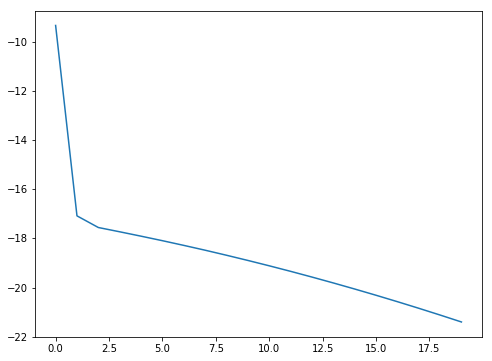

In [11]:
df = pd.DataFrame(history.history)
#display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
col = 'val_loss' if 'val_loss' in df else 'loss'
display(df[-25:])
df[col][-25:].plot(figsize=(8, 6))

# 2019-07-28

* Got some framework up to do coupling layers but having trouble passing the scale parameter to the loss function, getting some weird tensorflow error, needs more debugging
* Without the determinant in the loss function, it looks like loss goes down, so maybe on the right track?
    * It's actually weird that we're not using the image in the output, but I guess that's what's great about this reversible model!
* TODO:
    * Debug scale function in loss
    * Add reverse (generator) network to functions above.

# 2019-07-29

* Explanation of how to estimate probability of continuous variables (relevant for computing bits/pixel without an explicit discrete distribution): https://math.stackexchange.com/questions/2818318/probability-that-a-sample-is-generated-from-a-distribution
* Idea for a post, explain likelihood estimation of discrete vs. continuous distributions (like pixels), include:
  * Probability of observing a value from continuous distribution = 0
     * https://math.stackexchange.com/questions/2818318/probability-that-a-sample-is-generated-from-a-distribution
  * Probability of observing a value from a set of discrete hypthesis (models) is non-zero using epsilon trick (see above link):
     * https://math.stackexchange.com/questions/920241/can-an-observed-event-in-fact-be-of-zero-probability
  * Explain Equation 3 from "A NOTE ON THE EVALUATION OF GENERATIVE MODELS"
     * Also include an example using a simpler case, like a bernoulli variable that we're estimating using a continuous distribution
  * Bring it back to modelling pixels and how they usually do it

# 2020-03-30

* To make reversible network, build forward and backward network at the same time using `Model()` to have components that I can use in both networks
* Looks like I have some instability here, depending on the run I can get an exact fit (-100s loss) or a poor a fit (+10):
    * Turning off residual networks helps
    * Adjusting the learning rate, batch size helps but hard to pinpoint a methodology
* Most likely it's the instability of using a scale parameter (RealNVP paper Section 3.7), might need to implement their batch norm for more stable results, especially when adding more layers:
    * Reimplement `BatchNorm`: https://github.com/keras-team/keras/blob/master/keras/layers/normalization.py
    * Except return regular result AND (variance + eps) term
    * Use the (var + eps) term to compute Jacobian for loss function (should just be log-additive)
* Once this is done, add back the other stuff:
    * Turn on residual shortcuts
    * Change batch size to reasonable number and learning rate=0.01
* If this still doesn't work, might want to implement "Running average over recent minibatches" in Appendix E

# 2020-03-31

* Fixed a bug (I think) in the network where the coupling layer was wrong.  However, it still sometimes get stuck at around a loss of 5 but more often than not (on another training run) get to -10 (after 20 iters).
* Trying to get FlowBatchNorm worknig but having some issues passing the determinant batch loss as an output because the `batch_size` is not getting passed (it has dimension (3,) but should have dimension (None, 3)).  Need to figure out how to tranlate a tensor to Layer that includes batch.

# 2020-04-05

* Reminder: BatchNormalization on conv layers only need to normalize across [B, W, H, :] layers, not the "C" layer because the filter is identical across a channel (so it uses the same mean/var to normalize).  This is nice because it's the same axis (-1) you would normalize across in a Dense layer. See: https://intellipaat.com/community/3872/batch-normalization-in-convolutional-neural-network
* I think I figured out how to return the batchnorm weights back but now I'm hitting a roadblock when I try to merge them together to put as part of the output loss -- maybe I should just forget it and use the tensors directly in the output loss?
* Now that I switched to an explicit batch size, it doesn't run anymore... get this error "Incompatible shapes: [4] vs. [32]", probably some assumption that I had, got to work backwards and fix it I think.


# 2020-04-14

* Okay figured out the weird error I was getting: when a Keras model has multiple outputs you either have to give it a list or dict of loss functions, otherwise it will apply the same loss to each output!  Of course, I just assumed that it gives you all outputs in one loss function. So silly!
* I reverted the change to explicitly set batch. Instead in the `BatchNormFlow` layer I just multiply zero by the `inputs` and then add the mean/variance.  I think this gives the right shape?
* **TODOs**:
  * Check that shape/computation for `BatchNormFlow`/`batch_losses` loss is correct
  * Check that loss functions are actually returning a negative log-loss (not just the log)
  * Validate the model is fitting what I want (right now I have an elbow effect as I train more) -- should there be backprop through the batch_losses? I guess not?  Check the paper and figure out what to do.
  * Add back in the bigger model that has multiple coupling layers

# 2020-04-15

* Somehow I suspect that the batch loss is not getting optimized (the var parameter in the batch norm function).  When I set the other loss components to zero, I see that hte batch loss is not really getting smaller -- should it?

        loss 	coupling_check_even_1c_loss 	s_losses_loss 	batch_losses_loss
        0 	146.227879 	0.0 	0.0 	146.227879
        1 	131.294226 	0.0 	0.0 	131.294226
        2 	135.579913 	0.0 	0.0 	135.579913
        3 	127.908073 	0.0 	0.0 	127.908073
        4 	130.301921 	0.0 	0.0 	130.301921
        5 	139.414369 	0.0 	0.0 	139.414369
        6 	129.732767 	0.0 	0.0 	129.732767
        7 	127.321448 	0.0 	0.0 	127.321448
        8 	130.812973 	0.0 	0.0 	130.812973
        9 	136.737979 	0.0 	0.0 	136.737979
        10 	135.001893 	0.0 	0.0 	135.001893
        11 	140.181680 	0.0 	0.0 	140.181680
        12 	133.053322 	0.0 	0.0 	133.053322
        13 	132.912917 	0.0 	0.0 	132.912917
        14 	122.261415 	0.0 	0.0 	122.261415
        15 	139.447081 	0.0 	0.0 	139.447081
        16 	134.216364 	0.0 	0.0 	134.216364
        17 	133.567210 	0.0 	0.0 	133.567210
        18 	131.333447 	0.0 	0.0 	131.333447
        19 	133.022141 	0.0 	0.0 	133.022141
        
* **IDEA:** I should probably unit test the batch norm flow layer to make sure that it's doing what I think it should be doing... need to think about how to structure this experiment.
* **CHECK**: Should `s` loss be negated also?  Seems like I need negative log loss, not just log loss...

# 2020-04-16

* Forgot that BatchNorm has two components:  $\mu, \sigma^2$, the mean and variance of the batch, which we scale ($\hat{x} = \frac{x-\mu}{\sqrt{\sigma^2 + \epsilon}}$) AND two learnable parameters: $\gamma, \beta$, which are used to scale the output: $y = \gamma \hat{x} + \beta$.  The learnable parameters are the only ones that change!
* Now, how does that work when calculating the determinant? Let's see:

$$\frac{\partial}{\partial y} \hat{y} = \frac{\partial}{\partial y}\big[\gamma * \frac{x-\mu}{\sqrt{\sigma^2 + \epsilon} + \beta}\big]$$
$$ = \frac{\gamma}{\sqrt{\sigma^2 + \epsilon}}$$

  Therefore, I need to include gamma in the determinant calculation in the batch norm layer!
  
  
Ohhhhh... use `keras.layer.add_loss()` function instead of passing the new things over!  Not sure how to deal with batch though... https://www.tensorflow.org/guide/keras/custom_layers_and_models

# 2020-04-17

* Made some progress adding batch norm loss use both `layer.add_loss()` and `layer.add_metric()` so I can view it... BUT I need to upgrade to Tensorflow 2.0.  
* After upgrading to 2.0, might as well start using `tf.keras` directly as that's the recommendation from the site.

# 2020-04-20

* Upgraded to Tensorflow 2.1!  I hate upgrading things...
* Converted most of my code over too -- still need to add `layer.add_loss()` and `layer.add_metric()` to the `FlowBatchNorm()` layer though.  I did convert it over to the TF2 version, inheriting it and assuming that the fancier features are turned off.

In [ ]:
from scipy.stats import norm

for i in range(-10, 10):
    eps = i / 1000
    l = norm.cdf(0 - eps)
    r = norm.cdf(0 + eps)
    print(eps, '\t', l - r)

In [ ]:
a = np.array([[[-1, -2], [-3, -4]], [[1,2], [3, 4]], [[5,6], [7, 8]]])  
b = np.array([100, 200]).reshape([1, 1, 2])

c = a + b
c[:, :, :]